[[1.54092643e+04]
 [1.28762338e+03]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]
 [1.00000000e-02]]


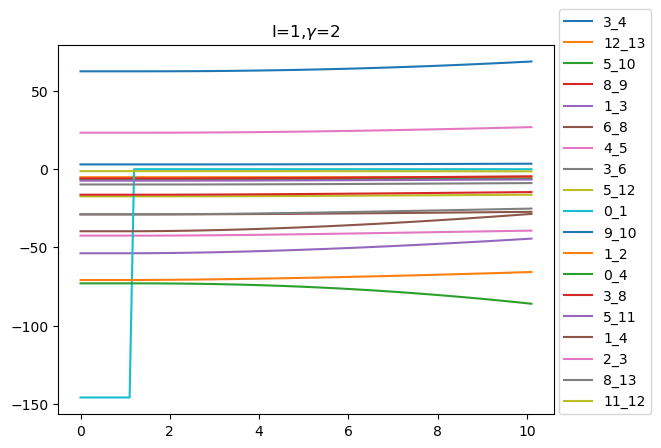

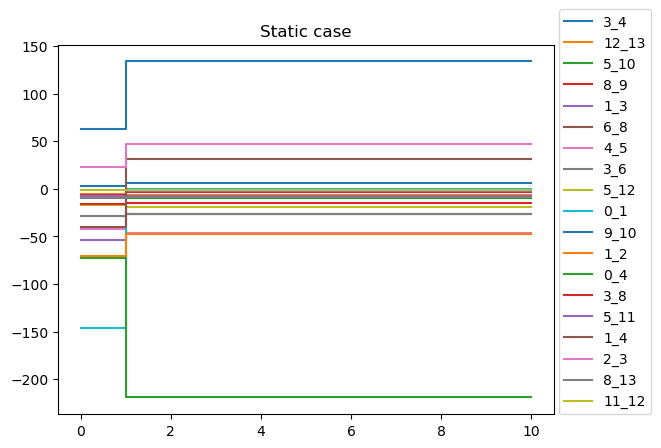

In [80]:
import numpy as np
from pathlib import Path
import cmath
import sys
import os
import importlib

sys.path.insert(0, os.path.abspath('../src'))
from modeling_cascading_failure import simulate
importlib.reload(simulate)

nprect = np.vectorize(cmath.rect)
npphase = np.vectorize(cmath.phase)
def convert_complex(x):
    return complex(x.replace("i","j"))
npconvert = np.vectorize(convert_complex)

# prepare inputs

num_buses = 14
eps=0.0000001
max_iter=100

# get data
Y = np.loadtxt(Path("./data") / "Y{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
Y = npconvert(Y)
v = np.loadtxt(Path("./data") / "v{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
v = npconvert(v)
slack = np.loadtxt(Path("./data") / "slack{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
slack = int(slack) - 1
s = np.loadtxt(Path("./data") / "s{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
s = npconvert(s)
pv = np.loadtxt(Path("./data") / "pv{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
pv = pv.astype(int) - 1
pq = np.loadtxt(Path("./data") / "pq{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
pq = pq.astype(int) - 1
base_mva = np.loadtxt(Path("./data") / "base_mva{}.csv".format(num_buses),
                 delimiter=",", dtype=str)
base_mva = float(base_mva)

# convert data
PV_x = np.array([1 if i in pv else 0 for i in range(Y.shape[0])]).reshape(-1,1)
PQ_x = np.array([1 if i in pq else 0 for i in range(Y.shape[0])]).reshape(-1,1)
x_slack = np.array([1 if i==slack else 0 for i in range(Y.shape[0])]).reshape(-1,1)
V_abs_full = abs(v).reshape(-1,1)
V_phase_full = npphase(v).reshape(-1,1)
P_full = np.real(s).reshape(-1,1)
Q_full = np.imag(s).reshape(-1,1)

# prepare inputs
V_abs = np.copy(V_abs_full)
V_abs[PQ_x==1] = 1

V_phase = np.copy(V_phase_full)
V_phase[x_slack==0] = 0

P_input = np.copy(P_full)
P_input[x_slack==1] = np.nan

Q_input = np.copy(Q_full)
Q_input[PQ_x==0] = np.nan

I = 1
gamma=2
t_max=10
I_array = np.ones(num_buses).reshape(-1,1)*I
gamma_array = np.ones(num_buses).reshape(-1,1)*gamma
(theta,omega,F,P,line_failures,node_failures,F_threshold,line_failures_static,flows_static)=simulate.simulate_system(
    Y,
    PV_x,
    PQ_x,
    x_slack,
    V_abs,
    V_phase,
    P_input,
    Q_input,
    eps,
    max_iter,
    base_MVA=base_mva,
    lines_to_cut=[(0,1)],
    nodes_to_cut=None,
    cut_time=1,
    delta_t=0.1,
    alpha=0.5,
    frequency_deviation_threshold=0.6,
    apply_freq_dev_during_sim=False,
    I=None,
    H=5,
    gamma=gamma_array,
    t_max=t_max,
    include_resistive_losses=False,
    ref_freq=60
)
import matplotlib.pyplot as plt
# note cutting (0,1) with alpha=0.5, no frequency deviation threshold, and no resistive losses produces desirable results

# dynamic case
lines = np.argwhere(np.abs(F.sel(time=0).values)>0)
lines = list(set([tuple(sorted(line)) for line in lines]))
fig,ax=plt.subplots()
for line in lines:
    data= F.sel(node_i=line[0],node_j=line[1])
    plt.plot(data.time,data.values,label="{}_{}".format(line[0],line[1]))
    plt.title("I={},$\gamma$={}".format(I,gamma))
    plt.legend(loc=(1.01,0))

# static case
lines = np.argwhere(np.abs(flows_static.sel(iteration=0).values)>0)
lines = list(set([tuple(sorted(line)) for line in lines]))
fig,ax=plt.subplots()
for line in lines:
    data= flows_static.sel(node_i=line[0],node_j=line[1])
    iterations = list(data.iteration) + [t_max]
    values = list(data.values) + [data.values[-1]]
    plt.step(iterations,values,label="{}_{}".format(line[0],line[1]),where="post")
    plt.title("Static case")
    plt.legend(loc=(1.01,0))

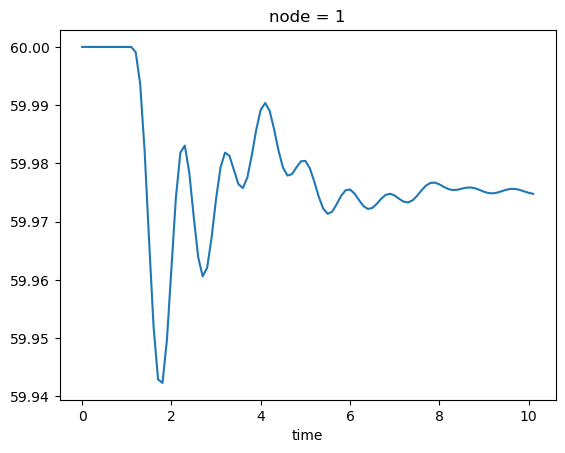

In [27]:
omega_hz = (omega.sel(node=1) / (2*np.pi)) + 60
omega_hz.plot()

In [69]:
60**2

3600